# complex evaluation array version

# load from prerunning data　bach-train

In [35]:
import sys,os
import numpy as np
from itertools import count
from collections import namedtuple
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Envのチェック

In [17]:
class G4env():
    def __init__(self, batch_size = 32):

        self.batch_size = batch_size
        self.angle = np.zeros(self.batch_size)
        self.r = 0
        self.done = torch.zeros(self.batch_size).view(self.batch_size,1)

        self.ang_range = 85
        self.event_num = 1000
        self.angle_step = 5.0
        self.ev_array = np.zeros((30,31,31))
        self.ev_array[15:20, 0:5, 0:5] = 10
        self.ev_array[0:20, 5:10, 5:10] = -0.1
        
        angles = [-90 + 5 * a for a in range(36)]
        self.dose = dict()
        for angle in angles:
            d = pd.read_csv("data/dose_t=" + str(angle) + ".csv")['dose']
            d = np.array(d).reshape(1,30,31,31) / self.event_num
            self.dose[angle] = d

    def reset(self):
        self.r = 0
        self.r_new = 0
        self.angle = np.zeros(self.batch_size)
        self.done = torch.zeros(self.batch_size).view(self.batch_size,1).to(device)

        states = np.array([self.dose[a] for a in self.angle])
        states = torch.tensor(states, dtype=torch.float32).to(device)
        
        return states

    def step(self, action):

        rewards = np.zeros(self.batch_size)
        
        for b in range(self.batch_size):
            
            self.angle[b] += self.angle_step * (action[b] - 1)
            if (np.abs(self.angle[b]) >= self.ang_range):
                self.done[b] = 1
            
            reward = self.ev_array * self.dose[self.angle[b]]
            self.r_new = reward.sum().sum()
            
            reward = self.r_new

            rewards[b] = reward
        # reward = self.r - self.r_new
        # self.r = self.r_new
        
        rewards = torch.tensor(rewards, dtype=torch.float32).view(self.batch_size, 1).to(device)
        
        states = np.array([self.dose[a] for a in self.angle])
        states = torch.from_numpy(states).float().to(device)
        return states, rewards, self.done

In [18]:
e = G4env()
dose = e.dose

In [148]:
dose[-20][0, 15:20, 0:5, 0:5].sum() #+20されている範囲の線量の合計

0.9182257799999999

In [149]:
dose[-20][0, 0:20, 5:10, 5:10].sum() #-1 で追加されている範囲の線量の合計

51.859664271

### check env

In [150]:
e = G4env()
states = e.reset()
for _ in range(2):
    a = np.random.randint(0,2,32)
    next_states = states
    states, rewards, dones, = e.step(a)
    print(states.shape, rewards.shape, dones.shape)

torch.Size([32, 1, 30, 31, 31]) torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1, 30, 31, 31]) torch.Size([32, 1]) torch.Size([32, 1])


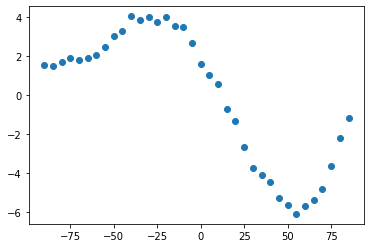

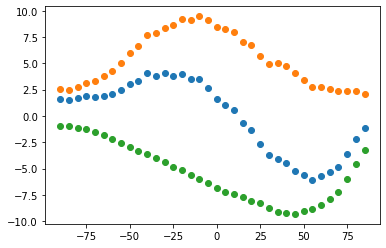

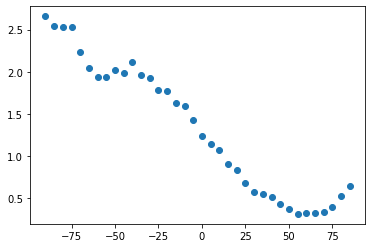

In [160]:
reward_lis = []
angle_lis  = []

plus = []
minus = []

for i in range(36):
    ang = -90 + 5 * i
    e.angle = ang * np.ones(e.batch_size)
    _, r, _ = e.step(np.ones(e.batch_size))
    reward_lis.append(r[0].item())
    angle_lis.append(ang)
    
    plus.append(e.dose[ang][0, 15:20, 0:5, 0:5].sum() * 10)
    minus.append(e.dose[ang][0, 0:20, 5:10, 5:10].sum() * -0.1)
    
    
    
plt.scatter(angle_lis, reward_lis)
plt.show()
sum_reward = [plus[i] + minus[i] for i in range(len(plus))]
plt.scatter(angle_lis, sum_reward)
plt.scatter(angle_lis, plus)
plt.scatter(angle_lis, minus)

plt.show()

ratio = [np.abs(plus[i] / minus[i]) for i in range(len(plus))]
plt.scatter(angle_lis, ratio)
plt.show()

In [34]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

x = np.array([0.5 * i for i in range(31) for j in range(31) for k in range(30)])
y = np.array([0.5 * j for i in range(31) for j in range(31) for k in range(30)])
z = np.array([0.5 * k for i in range(31) for j in range(31) for k in range(30)])

c = e.ev_array.reshape(31 * 31 * 30)

fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color="blue", alpha = 0.1, label='label')

ax.set_title('title')

ax.set_xlabel('X-label')
ax.set_ylabel('Y-label')
ax.set_zlabel('Z-label')

ax.legend()

plt.show()

ModuleNotFoundError: No module named 'ipympl'

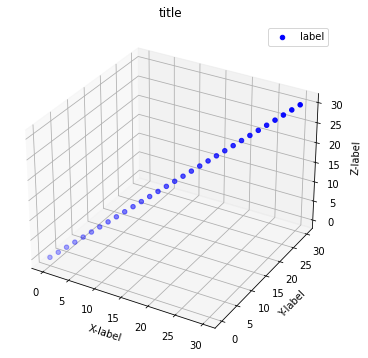

In [25]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([i for i in range(31)])
y = np.array([j for j in range(31)])
z = np.array([k for k in range(31)])

fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color="blue", label='label')

ax.set_title('title')

ax.set_xlabel('X-label')
ax.set_ylabel('Y-label')
ax.set_zlabel('Z-label')

ax.legend()

plt.show()

得点がある部分(+, or -の部分だけでいいのではないか。

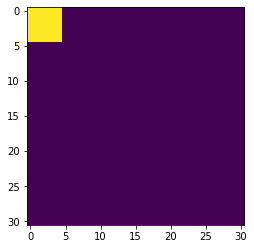

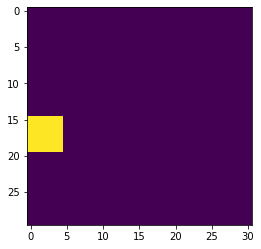

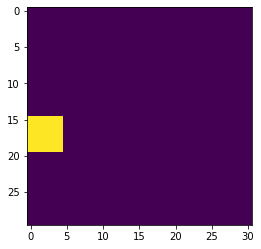

In [143]:
plt.imshow(G4env().ev_array.sum(0))
plt.show()
plt.imshow(G4env().ev_array.sum(1))
plt.show()
plt.imshow(G4env().ev_array.sum(2))
plt.show()

# Let's train

In [54]:
class NetWork(nn.Module):
    def __init__(self, nch_g=32):
        super(NetWork, self).__init__()

        self.batch_size = 32
        
        self.conv1 = nn.Conv3d(1        , nch_g    , 2)
        self.conv2 = nn.Conv3d(nch_g    , nch_g * 2, 2)
        self.conv3 = nn.Conv3d(nch_g * 2, nch_g * 4, 2)

        self.relu  = nn.ReLU()
        self.flat  = nn.Flatten()

        self.policy= nn.Linear(128 * 27 * 28 * 28, 3)
        self.value = nn.Linear(128 * 27 * 28 * 28, 1)
        self.sfmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        #----------------
        x = self.conv1(x)
        x = self.relu(x)
        #----------------
        x = self.conv2(x)
        x = self.relu(x)
        #----------------
        x = self.conv3(x)
        x = self.relu(x)
        #----------------
        x = self.flat(x)
        #----------------
        probs = self.policy(x)
        probs = self.sfmax(probs)
        
        value  = self.value(x)
        
        return probs, value
        

In [55]:
class BatchNormNetWork(nn.Module):
    def __init__(self, nch_g=32):
        super(BatchNormNetWork, self).__init__()

        self.batch_size = 32
        
        self.conv1 = nn.Conv3d(1        , nch_g    , 3, padding=1)
        self.bn1 = nn.BatchNorm3d(nch_g)
        self.conv2 = nn.Conv3d(nch_g    , nch_g * 2, 3, padding=1)
        self.bn2 = nn.BatchNorm3d(nch_g * 2)
        self.conv3 = nn.Conv3d(nch_g * 2, nch_g * 4, 3, padding=1)
        self.bn3 = nn.BatchNorm3d(nch_g * 4)

        self.relu  = nn.LeakyReLU(0.2, inplace=True)
        self.pool = nn.MaxPool3d(2)

        self.flat  = nn.Flatten()

        self.policy= nn.Linear(nch_g * 4 * 9 * 14 * 14, 3)
        self.value = nn.Linear(nch_g * 4 * 9 * 14 * 14, 1)
        self.sfmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        #----------------
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        #----------------
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        #----------------
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        #----------------
        x = self.flat(x)
        #----------------
        probs = self.policy(x)
        probs = self.sfmax(probs)
        
        value  = self.value(x)
        
        return probs, value


### Check get action

In [56]:
net = NetWork().to(device)
probs, _ = net(states)

batch_size = states.size(0)
actions = torch.multinomial(probs, 1)

selected_probs = torch.gather(probs, 1, actions)

print(actions.shape, selected_probs.shape)
print(rewards.shape)

torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1])


### Check update

In [57]:
gamma = 0.01
lr_pi = 0.0002
lr_v = 0.0005
done = 0

optimizer_pi = optim.Adam(net.parameters(), lr=lr_pi)
optimizer_v = optim.Adam(net.parameters(), lr=lr_v)

# ========== (1) Update V network ============
_, v_next_states = net(next_states)
print(rewards.shape, v_next_states.shape)
print((gamma * v_next_states * (1-done)).shape)
with torch.no_grad():
    targets = rewards + gamma * v_next_states * (1 - done)
_, v_states = net(states)

print(targets.shape)
loss_v = F.mse_loss(v_states, targets)

# ========== (2) Update pi network ===========
with torch.no_grad():
    deltas = targets - v_states

loss_pi = torch.mean(-torch.log(selected_probs) * deltas)

# ========== (3) Calculate loss ===============
loss = loss_pi + loss_v

optimizer_v.zero_grad()
optimizer_pi.zero_grad()

loss.mean().backward()

optimizer_v.step()
optimizer_pi.step()

torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1])
torch.Size([32, 1])


In [58]:
class AgentSingleNet:
    def __init__(self):
        self.gamma = 0.98
        self.lr_pi = 0.0000002
        self.lr_v = 0.0000005
        self.action_size = 3

        self.net = NetWork().to(device)
        
        self.optimizer_pi = optim.Adam(self.net.parameters(), lr=self.lr_pi)
        self.optimizer_v = optim.Adam(self.net.parameters(), lr=self.lr_v)
        
    def get_action(self, state):
        probs, _ = self.net(state)
        
        batch_size = state.size(0)
        actions = torch.multinomial(probs, 1)
        
        selected_probs = torch.gather(probs, 1, actions)
        return actions, selected_probs
        
    def update(self, states, actions_probs, rewards, next_states, dones):
        # ========== (1) Update V network ============
        _, v_next_states = self.net(next_states)
        with torch.no_grad():
            targets = rewards + self.gamma * v_next_states * (1 - dones)
        _, v_states = self.net(states)
        loss_v = F.mse_loss(v_states, targets)
        
        # ========== (2) Update pi network ===========
        with torch.no_grad():
            deltas = targets - v_states

        loss_pi = torch.mean(-torch.log(actions_probs) * deltas)
        
        # ========== (3) Calculate loss ===============
        loss = loss_pi + loss_v
        
        self.optimizer_v.zero_grad()
        self.optimizer_pi.zero_grad()

        loss.backward(retain_graph=True)  

        self.optimizer_v.step()
        self.optimizer_pi.step()


### agent test

In [60]:
import collections
import time

episodes   = 100
batch_size = 32

env = G4env(batch_size)
agent = AgentSingleNet()

reward_lis = []
angles  = []
begin = time.time()

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    count = 0
    print(episode)
    while 1:
        action, prob = agent.get_action(state)
        next_state, reward, done = env.step(action)
        total_reward += reward.sum()
        count += 1

        agent.update(state, prob, reward, next_state, done)
        state = next_state
#         print("episode: ",episode,"step: ", count, "probs: ", prob, "actions: ", action, "angle: ", env.angle)
#         print("reward: ",reward)
        angles.append(env.angle[0])
        
        if count > 100:
            break
        if done.sum() > 0:
            break
    
    reward_lis.append(total_reward.item() / batch_size)
        
    if episode % 10 == 0:
        torch.save(agent, "model04/actor-critic" + str(episode))
end = time.time()
print("elapsed time is ", end - begin, "s")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
elapsed time is  295.03851771354675 s


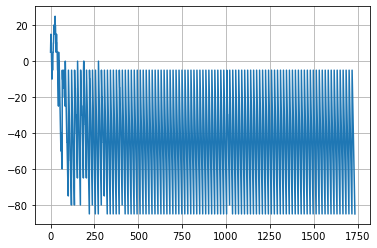

In [61]:
plt.plot(angles)
plt.grid()

In [62]:
env.angle

array([-85., -85., -85., -85., -85., -85., -85., -85., -85., -85., -85.,
       -85., -85., -85., -85., -85., -85., -85., -85., -85., -85., -85.,
       -85., -85., -85., -85., -85., -85., -85., -85., -85., -85.])

In [63]:
probs

tensor([[0.3372, 0.3397, 0.3230],
        [0.3349, 0.3412, 0.3239],
        [0.3349, 0.3412, 0.3239],
        [0.3349, 0.3412, 0.3239],
        [0.3353, 0.3399, 0.3248],
        [0.3372, 0.3397, 0.3230],
        [0.3353, 0.3399, 0.3248],
        [0.3349, 0.3412, 0.3239],
        [0.3372, 0.3397, 0.3230],
        [0.3372, 0.3397, 0.3230],
        [0.3353, 0.3399, 0.3248],
        [0.3349, 0.3412, 0.3239],
        [0.3349, 0.3412, 0.3239],
        [0.3349, 0.3412, 0.3239],
        [0.3353, 0.3399, 0.3248],
        [0.3353, 0.3399, 0.3248],
        [0.3349, 0.3412, 0.3239],
        [0.3372, 0.3397, 0.3230],
        [0.3353, 0.3399, 0.3248],
        [0.3353, 0.3399, 0.3248],
        [0.3349, 0.3412, 0.3239],
        [0.3372, 0.3397, 0.3230],
        [0.3372, 0.3397, 0.3230],
        [0.3349, 0.3412, 0.3239],
        [0.3372, 0.3397, 0.3230],
        [0.3349, 0.3412, 0.3239],
        [0.3353, 0.3399, 0.3248],
        [0.3353, 0.3399, 0.3248],
        [0.3349, 0.3412, 0.3239],
        [0.337

In [64]:
reward

tensor([[-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229],
        [-4.8229]], device='cuda:1')

In [65]:
reward_lis

[-2041.5972900390625,
 -607.3330078125,
 -532.4995727539062,
 -474.9626770019531,
 -452.8917236328125,
 -418.8292236328125,
 -422.74261474609375,
 -422.69354248046875,
 -390.82257080078125,
 -391.8130187988281,
 -388.4189147949219,
 -388.9317932128906,
 -376.8341979980469,
 -375.0367736816406,
 -375.9881286621094,
 -383.9181213378906,
 -373.4056396484375,
 -375.9552001953125,
 -370.4021301269531,
 -367.0992126464844,
 -367.9613037109375,
 -365.77490234375,
 -364.0028381347656,
 -366.7359924316406,
 -367.2105712890625,
 -365.2139587402344,
 -364.9334716796875,
 -364.77325439453125,
 -363.6541748046875,
 -364.15557861328125,
 -364.6846923828125,
 -368.3778076171875,
 -364.26226806640625,
 -363.6541748046875,
 -363.6541748046875,
 -364.0028381347656,
 -364.6846923828125,
 -363.6541748046875,
 -363.6541748046875,
 -363.6541748046875,
 -363.6541748046875,
 -363.6968994140625,
 -363.6541748046875,
 -364.6190490722656,
 -363.6541748046875,
 -363.6541748046875,
 -363.6541748046875,
 -363.65417

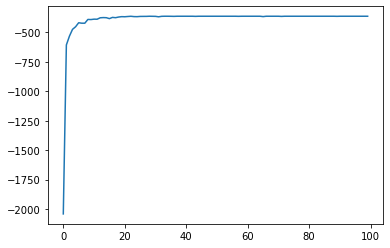

In [66]:
plt.plot(reward_lis)

# 結果

学習が進み、最高の得点を得られる照射角度である-85度に移動することが確認できた。

学習速度は、報酬の角度分布が学習しやすい形状だったからと考えられる。

-5度で当てることで最高の線量が得られる報酬行列に追加して線量が当たることで得点が下がる部分を追加したことでactionが変更されていることが確認できた。

報酬の与え方は難しい。一定の線量を標的に当て、かつ他の範囲への線量を少なくする必要があるため。